In [1]:
from datasets import flickr8k_parse
from keras import Model
from keras.applications import VGG16
from keras.models import model_from_json
from nltk.translate.bleu_score import corpus_bleu
from scipy import misc
from tqdm import tqdm_notebook as tqdm

import image_preprocessing
import matplotlib.pyplot as plt
import math
import numpy as np
import path_generation
import text_processing

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_vocab = text_processing.Vocabulary()
train_vocab.load_vocabulary('./vocabulary/word_to_id.pickle', './vocabulary/id_to_word.pickle')

In [3]:
batch_size = 32
dataset = 'flickr8k'
initial_state_size = 512
embedding_out_size = 512
number_of_layers = 2
max_len = 30
batch_norm = True
dropout = True
gru = False
attn = True
attn_type = 'bahdanau'
beam_size = 3
path_gen = path_generation.PathGenerator(gru, dataset, number_of_layers, batch_size, batch_norm, dropout, attn, attn_type, beam_size)

path_checkpoint = path_gen.get_weights_path()
model_path = path_gen.get_model_path()
captions_path = path_gen.get_captions_path()

In [4]:
if attn:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_train_attn.npy')
    val_transfer_values = np.load('./cnn_features/vgg16_flickr8k_val_attn.npy')
else:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_train.npy')
    val_transfer_values = np.load('./cnn_features/vgg16_flickr8k_val.npy')

In [5]:
initial_state_size = 512
with open(model_path, 'r') as json_file:
    loaded_model_json = json_file.read()

decoder_model = model_from_json(loaded_model_json)
# load weights into new model
decoder_model.load_weights(path_checkpoint)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Encoder model for predictions

In [6]:
VGG_model = VGG16(include_top=True, weights='imagenet')
transfer_layer = VGG_model.get_layer('fc2')
if attn:
    transfer_layer = VGG_model.get_layer('block5_conv3')
VGG_transfer_model = Model(inputs=VGG_model.input, outputs=transfer_layer.output)
input_layer = VGG_model.get_layer('input_1')
VGG_image_size = input_layer.input_shape[1:3]

In [7]:
def generate_caption(image, model_image_size, decoder_model, transfer_model, vocabulary, transfer_values=False, beam_size=3, max_caption_len=30, attn=False, get_weights=False):
    """
    Generates a caption for a given image
    
    """
    if transfer_values:
        if attn:
            input_transfer_values = image.reshape((1, 196, 512))
        else:
            input_transfer_values = image.reshape((1, 4096))
    else:
        img = image_preprocessing.image_preprocessing(image, model_image_size)
        image_batch = np.expand_dims(img, axis=0)
        input_transfer_values = transfer_model.predict(image_batch)
        if attn:
            input_transfer_values = np.reshape(input_transfer_values, [-1, 196, 512])
    
    decoder_inputs = np.zeros(shape=(1, max_caption_len), dtype=np.int)
    captions = [[[vocabulary.get_id_by_word('<sos>')], 0.0]]
    
    weights = []
    for i in range(max_caption_len - 1):
        tmp_caps = []
        for caption in captions:
            sentence, score = caption
            if sentence[-1] == vocabulary.get_id_by_word('<eos>'):
                tmp_caps.append(caption)
                continue
            
            decoder_inputs[0, :len(sentence)] = sentence

            input_data = {
                'encoder_input': input_transfer_values,
                'decoder_input': decoder_inputs
            }
            
            decoder_output = decoder_model.predict(input_data)
                
            candidates = decoder_output[0, i, :].argsort()[-beam_size:]
            
            for candidate in candidates:
                sentence.append(candidate)
                caption = [sentence, score + np.log(decoder_output[0, i, candidate])]
                sentence = sentence[:-1]
                tmp_caps.append(caption)
                
        captions = sorted(tmp_caps, key=lambda x: x[1], reverse=True)[:beam_size]
    
    for i in range(beam_size):
        captions[i][1] /= len(captions[0][0])
        
    captions = sorted(tmp_caps, key=lambda x: x[1], reverse=True)
    
    if attn and get_weights:
        outputs = []
        for i in range(len(captions[0][0])):
            attn_weight_layer = decoder_model.get_layer('weights_{}'.format(i)).output
            outputs.append(attn_weight_layer)
        decoder_inputs[0, :len(captions[0][0])] = captions[0][0]
        input_data = {
            'encoder_input': input_transfer_values,
            'decoder_input': decoder_inputs
        }
        attn_weight_model = Model(inputs=decoder_model.inputs, outputs=outputs)
        weights = attn_weight_model.predict(input_data)

    if not transfer_values:
        plt.imshow(img)
        plt.show()
        for i in range(beam_size):
            print(" ".join([vocabulary.get_word_by_id(x) for x in captions[i][0][1:-1]]), "{:.3f}".format(captions[i][1]))
    
    if attn and get_weights:
        return [vocabulary.get_word_by_id(x) for x in captions[0][0][1:-1]], weights
    else:
        return [vocabulary.get_word_by_id(x) for x in captions[0][0][1:-1]]

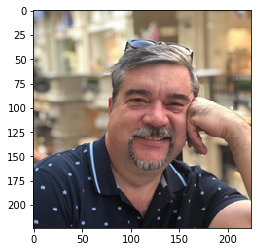

a woman wearing a black hat and glasses -0.994
a woman wearing a black hat and glasses is smiling -1.178
a woman wearing a black hat with a black hat and glasses -1.626


In [8]:
get_weights = True
path = 'C:/Users/User/Desktop/test_photos/ds.jpg'

result = generate_caption(path, VGG_image_size, decoder_model, VGG_transfer_model, train_vocab, beam_size=beam_size, attn=attn, get_weights=get_weights)
if get_weights:
    caption, weights = result
else:
    caption = result

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


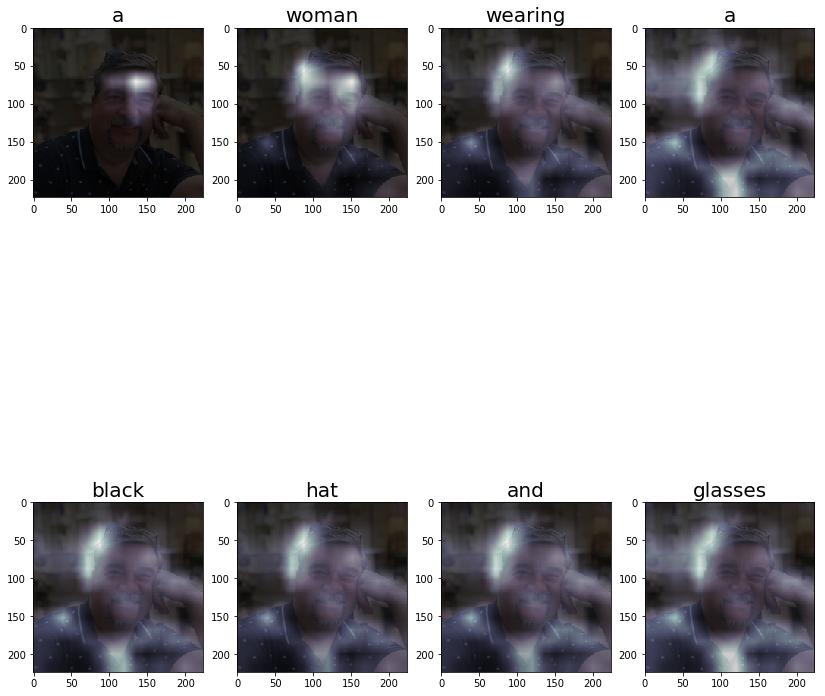

In [9]:
if get_weights:
    cols = 4
    rows = math.ceil(len(caption) / cols)
    fig = plt.figure(figsize=(14, 16))
    for word_num in range(len(caption)):
        weights_img = np.reshape(weights[word_num], [14,14])
        weights_img = misc.imresize(weights_img, (224, 224))
        img = image_preprocessing.image_preprocessing(path, (224,224))
        plt.subplot(rows, cols, word_num + 1)
        plt.title(caption[word_num], fontsize=20)
        plt.imshow(img)
        plt.imshow(weights_img, cmap='bone', alpha=0.8)
    plt.show()

In [10]:
images_path = 'D:/Flickr8k/images/'
annotations_path = 'D:/Flickr8k/annotations/'
captions_file = 'D:/Flickr8k/annotations/Flickr8k.token.txt'
train_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.trainImages.txt'
dev_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.devImages.txt'
test_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.testImages.txt'

filenames_with_all_captions = flickr8k_parse.generate_filenames_with_all_captions(captions_file, images_path)

test_filenames_with_all_captions = flickr8k_parse.generate_set(test_txt_path, filenames_with_all_captions, images_path)

test_captions = flickr8k_parse.make_list_of_captions(test_filenames_with_all_captions)

In [11]:
list(test_filenames_with_all_captions.keys())

['D:/Flickr8k/images/3385593926_d3e9c21170.jpg',
 'D:/Flickr8k/images/2677656448_6b7e7702af.jpg',
 'D:/Flickr8k/images/311146855_0b65fdb169.jpg',
 'D:/Flickr8k/images/1258913059_07c613f7ff.jpg',
 'D:/Flickr8k/images/241347760_d44c8d3a01.jpg',
 'D:/Flickr8k/images/2654514044_a70a6e2c21.jpg',
 'D:/Flickr8k/images/2339106348_2df90aa6a9.jpg',
 'D:/Flickr8k/images/256085101_2c2617c5d0.jpg',
 'D:/Flickr8k/images/280706862_14c30d734a.jpg',
 'D:/Flickr8k/images/3072172967_630e9c69d0.jpg',
 'D:/Flickr8k/images/3482062809_3b694322c4.jpg',
 'D:/Flickr8k/images/1167669558_87a8a467d6.jpg',
 'D:/Flickr8k/images/2847615962_c330bded6e.jpg',
 'D:/Flickr8k/images/3344233740_c010378da7.jpg',
 'D:/Flickr8k/images/2435685480_a79d42e564.jpg',
 'D:/Flickr8k/images/3110649716_c17e14670e.jpg',
 'D:/Flickr8k/images/2511019188_ca71775f2d.jpg',
 'D:/Flickr8k/images/2521770311_3086ca90de.jpg',
 'D:/Flickr8k/images/2723477522_d89f5ac62b.jpg',
 'D:/Flickr8k/images/2218609886_892dcd6915.jpg',
 'D:/Flickr8k/images/374

In [12]:
text_processing.preprocess_captions(test_captions)

In [13]:
references = []
for list_captions in test_captions:
    reference = []
    for caption in list_captions:
        reference.append(caption.split())
    references.append(reference)

In [14]:
references[0]

[['the',
  'dogs',
  'are',
  'in',
  'the',
  'snow',
  'in',
  'front',
  'of',
  'a',
  'fence'],
 ['the', 'dogs', 'play', 'on', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'wrestle', 'in', 'the', 'snow'],
 ['two', 'dogs', 'playing', 'in', 'the', 'snow']]

In [15]:
if attn:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test_attn.npy')
else:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test.npy')

In [16]:
transfer_values.shape

(1000, 14, 14, 512)

In [17]:
def generate_test_captions(test_images, *args):
    """
    Generate captions for bunch of validation captions
    """
    captions = []
    for i, image in tqdm(enumerate(test_images)):
        captions.append(generate_caption(image, *args))
 
    return captions

In [18]:
generated_captions = generate_test_captions(transfer_values, VGG_image_size, decoder_model, VGG_transfer_model, train_vocab, True, beam_size, 30, True, False)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [19]:
with open(captions_path, 'w') as captions_file:
    for caption in generated_captions:
        captions_file.write(" ".join(caption))
        captions_file.write("\n")

In [20]:
print('{:.3f}'.format(corpus_bleu(references, generated_captions, weights=(1,0,0,0)) * 100))

55.174


In [21]:
print('{:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.5,0.5)) * 100))

35.941


In [22]:
print('{:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.33,0.33,0.33,0)) * 100))

23.557


In [23]:
print('{:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.25,0.25,0.25,0.25)) * 100))

15.013
